In [2]:
!nvidia-smi

Sun Sep  3 13:30:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [73]:
# Install the latest JAXlib version.
#!pip install --upgrade -q pip jax jaxlib
!pip install --upgrade -q "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git
# Install CLU or Common Loop Utils
!pip install -q clu
# Install Orbax
!pip install orbax-checkpoint

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import jax
from jax import random, numpy as jnp
from flax import linen as nn

In [5]:
jax.devices()

[gpu(id=0)]

## Dataset

In [6]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
#tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# As the dataset does not contain any train/test split
# we make our own split into train and test dataset.
# as_supervised=True gives us the (image, label) as a tuple instead of a dict
data, info = tfds.load(name="cats_vs_dogs",
                       data_dir=data_dir,
                       split=["train[:80%]", "train[80%:]"],
                       as_supervised=True,
                       with_info=True)

(cats_dogs_data_train, cats_dogs_data_test) = data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /tmp/tfds/cats_vs_dogs/4.0.0.incomplete47V39J/cats_vs_dogs-train.tfrecord*...:   0%|          | 0/23…

Dataset cats_vs_dogs downloaded and prepared to /tmp/tfds/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [7]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path=PosixGPath('/tmp/tmp0t739v95tfds'),
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
  

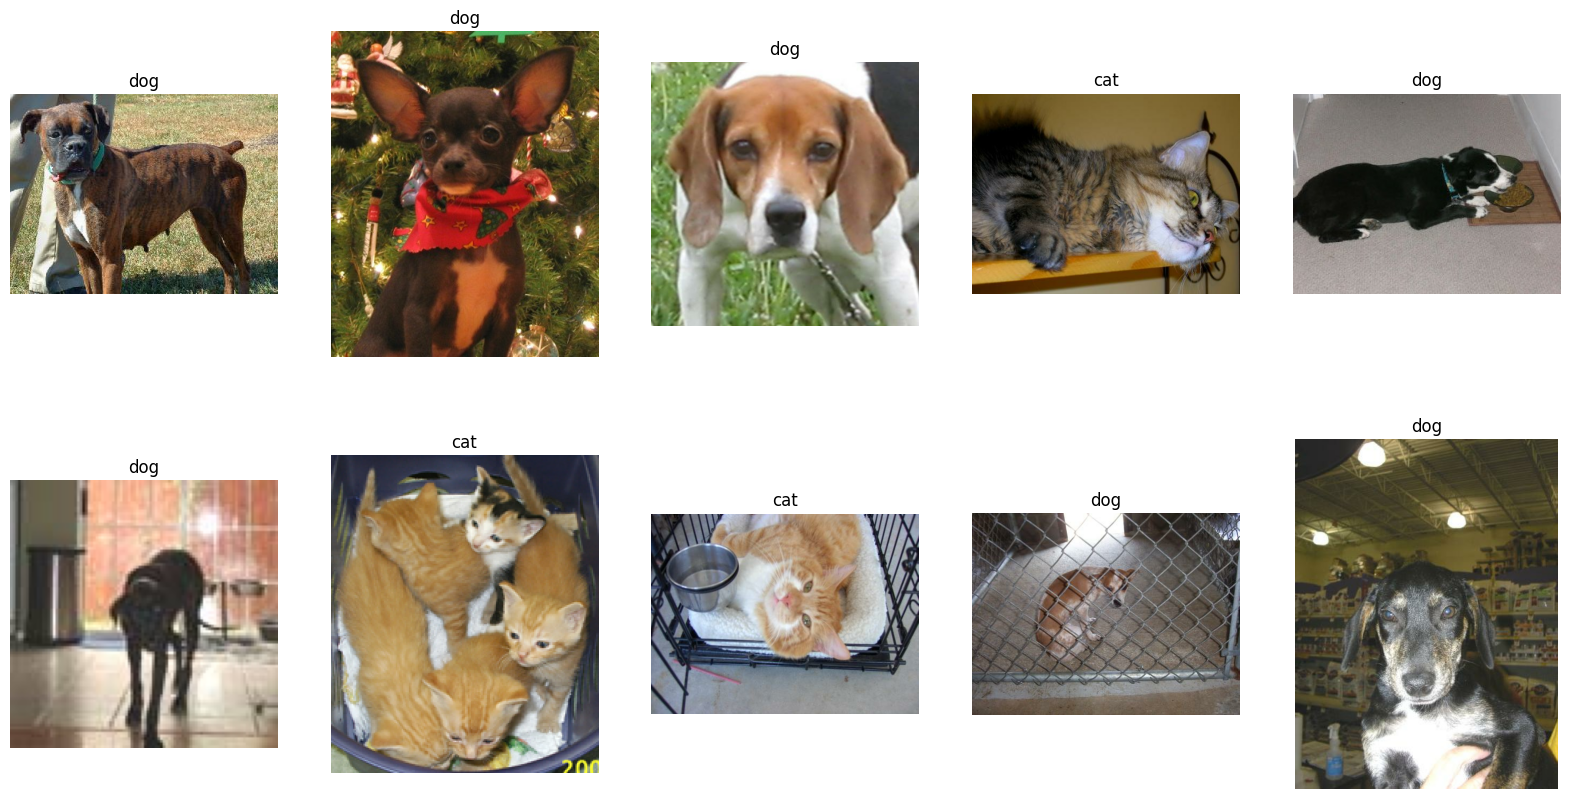

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

CLASS_NAMES = ['cat', 'dog']
ROWS = 2
COLS = 5

i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in cats_dogs_data_train.take(ROWS*COLS):
    ax[int(i/COLS), i%COLS].axis('off')
    ax[int(i/COLS), i%COLS].set_title(CLASS_NAMES[label])
    ax[int(i/COLS), i%COLS].imshow(image)
    i += 1

plt.show()

In [9]:
HEIGHT = 100
WIDTH  = 100
CHANNELS = 3
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS
NUM_LABELS = info.features['label'].num_classes

In [10]:
def preprocess(img, label):
  """Resize and preprocess images."""
  return tf.image.resize(img, [HEIGHT, WIDTH]) / 255.0, tf.cast(label, tf.int32)

In [11]:
cats_dogs_data_train_vis = cats_dogs_data_train.map(preprocess)

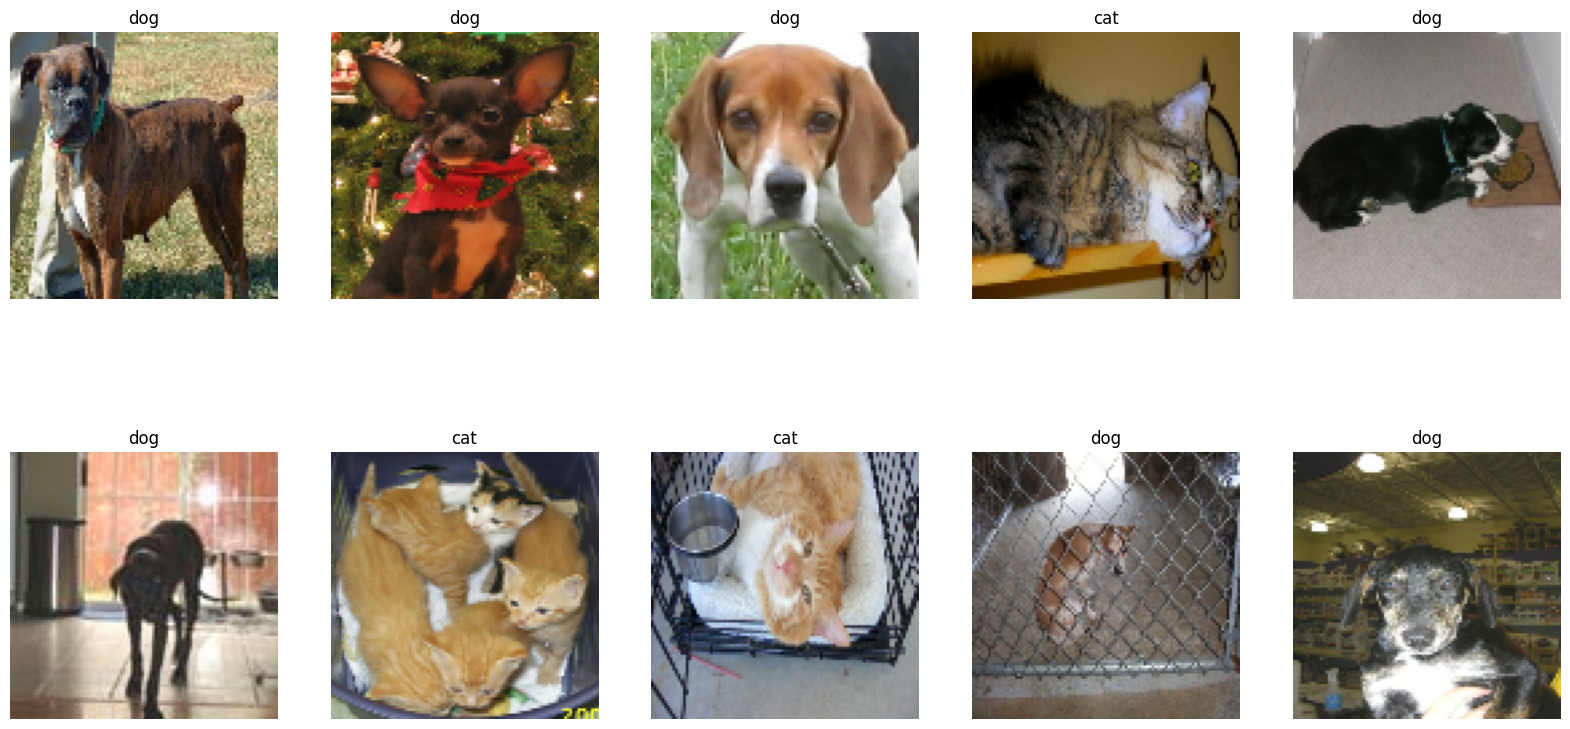

In [12]:
i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in cats_dogs_data_train_vis.take(ROWS*COLS):
    ax[int(i/COLS), i%COLS].axis('off')
    ax[int(i/COLS), i%COLS].set_title(CLASS_NAMES[label])
    ax[int(i/COLS), i%COLS].imshow(image)
    i += 1

plt.show()

In [13]:
train_data = tfds.as_numpy(cats_dogs_data_train.map(preprocess).batch(32).prefetch(1))
test_data  = tfds.as_numpy(cats_dogs_data_test.map(preprocess).batch(32).prefetch(1))

# Network

In [14]:
from functools import partial
from typing import Any, Callable, Sequence, Tuple

ModuleDef = Any

In [15]:
class ResNetBlock(nn.Module):
  """ResNet block."""
  filters: int
  conv: ModuleDef
  norm: ModuleDef
  act: Callable
  strides: Tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(self, x,):
    residual = x
    y = self.conv(self.filters, (3, 3), self.strides)(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3))(y)
    y = self.norm(scale_init=nn.initializers.zeros_init())(y)

    if residual.shape != y.shape:
      residual = self.conv(self.filters, (1, 1),
                           self.strides, name='conv_proj')(residual)
      residual = self.norm(name='norm_proj')(residual)

    return self.act(residual + y)

In [16]:
class BottleneckResNetBlock(nn.Module):
  """Bottleneck ResNet block."""
  filters: int
  conv: ModuleDef
  norm: ModuleDef
  act: Callable
  strides: Tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(self, x):
    residual = x
    y = self.conv(self.filters, (1, 1))(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3), self.strides)(y)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters * 4, (1, 1))(y)
    y = self.norm(scale_init=nn.initializers.zeros_init())(y)

    if residual.shape != y.shape:
      residual = self.conv(self.filters * 4, (1, 1),
                           self.strides, name='conv_proj')(residual)
      residual = self.norm(name='norm_proj')(residual)

    return self.act(residual + y)

In [17]:
class ResNet(nn.Module):
  """ResNetV1."""
  stage_sizes: Sequence[int]
  block_cls: ModuleDef
  num_classes: int
  num_filters: int = 64
  dtype: Any = jnp.float32
  act: Callable = nn.relu
  conv: ModuleDef = nn.Conv

  @nn.compact
  def __call__(self, x, train: bool = True):
    conv = partial(self.conv, use_bias=False, dtype=self.dtype)
    norm = partial(nn.BatchNorm,
                   use_running_average=not train,
                   momentum=0.9,
                   epsilon=1e-5,
                   dtype=self.dtype)
                   #axis_name='batch')


    x = conv(self.num_filters, (7, 7), (2, 2),
             padding=[(3, 3), (3, 3)],
             name='conv_init')(x)
    x = norm(name='bn_init')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, (3, 3), strides=(2, 2), padding='SAME')
    for i, block_size in enumerate(self.stage_sizes):
      for j in range(block_size):
        strides = (2, 2) if i > 0 and j == 0 else (1, 1)
        x = self.block_cls(self.num_filters * 2 ** i,
                           strides=strides,
                           conv=conv,
                           norm=norm,
                           act=self.act)(x)
    x = jnp.mean(x, axis=(1, 2))
    x = nn.Dense(self.num_classes, dtype=self.dtype)(x)
    x = jnp.asarray(x, self.dtype)
    return x


In [18]:
ResNet18 = partial(ResNet, stage_sizes=[2, 2, 2, 2],
                   block_cls=ResNetBlock)
ResNet34 = partial(ResNet, stage_sizes=[3, 4, 6, 3],
                   block_cls=ResNetBlock)
ResNet50 = partial(ResNet, stage_sizes=[3, 4, 6, 3],
                   block_cls=BottleneckResNetBlock)
ResNet101 = partial(ResNet, stage_sizes=[3, 4, 23, 3],
                    block_cls=BottleneckResNetBlock)
ResNet152 = partial(ResNet, stage_sizes=[3, 8, 36, 3],
                    block_cls=BottleneckResNetBlock)
ResNet200 = partial(ResNet, stage_sizes=[3, 24, 36, 3],
                    block_cls=BottleneckResNetBlock)

In [19]:
model = ResNet18(num_classes=NUM_LABELS)

In [20]:
images, labels = next(iter(train_data))

In [21]:
images.shape

(32, 100, 100, 3)

In [22]:
labels.shape

(32,)

In [53]:
key1, key2 = random.split(random.PRNGKey(0))
variables = model.init(key2, images)

In [54]:
type(variables)

dict

In [55]:
variables.keys()

dict_keys(['params', 'batch_stats'])

In [57]:
model_state, params = flax.core.pop(variables, 'params')

In [58]:
jax.tree_util.tree_map(lambda x: x.shape, model_state)

{'batch_stats': {'ResNetBlock_0': {'BatchNorm_0': {'mean': (64,),
    'var': (64,)},
   'BatchNorm_1': {'mean': (64,), 'var': (64,)}},
  'ResNetBlock_1': {'BatchNorm_0': {'mean': (64,), 'var': (64,)},
   'BatchNorm_1': {'mean': (64,), 'var': (64,)}},
  'ResNetBlock_2': {'BatchNorm_0': {'mean': (128,), 'var': (128,)},
   'BatchNorm_1': {'mean': (128,), 'var': (128,)},
   'norm_proj': {'mean': (128,), 'var': (128,)}},
  'ResNetBlock_3': {'BatchNorm_0': {'mean': (128,), 'var': (128,)},
   'BatchNorm_1': {'mean': (128,), 'var': (128,)}},
  'ResNetBlock_4': {'BatchNorm_0': {'mean': (256,), 'var': (256,)},
   'BatchNorm_1': {'mean': (256,), 'var': (256,)},
   'norm_proj': {'mean': (256,), 'var': (256,)}},
  'ResNetBlock_5': {'BatchNorm_0': {'mean': (256,), 'var': (256,)},
   'BatchNorm_1': {'mean': (256,), 'var': (256,)}},
  'ResNetBlock_6': {'BatchNorm_0': {'mean': (512,), 'var': (512,)},
   'BatchNorm_1': {'mean': (512,), 'var': (512,)},
   'norm_proj': {'mean': (512,), 'var': (512,)}},
  

In [59]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'Dense_0': {'bias': (2,), 'kernel': (512, 2)},
 'ResNetBlock_0': {'BatchNorm_0': {'bias': (64,), 'scale': (64,)},
  'BatchNorm_1': {'bias': (64,), 'scale': (64,)},
  'Conv_0': {'kernel': (3, 3, 64, 64)},
  'Conv_1': {'kernel': (3, 3, 64, 64)}},
 'ResNetBlock_1': {'BatchNorm_0': {'bias': (64,), 'scale': (64,)},
  'BatchNorm_1': {'bias': (64,), 'scale': (64,)},
  'Conv_0': {'kernel': (3, 3, 64, 64)},
  'Conv_1': {'kernel': (3, 3, 64, 64)}},
 'ResNetBlock_2': {'BatchNorm_0': {'bias': (128,), 'scale': (128,)},
  'BatchNorm_1': {'bias': (128,), 'scale': (128,)},
  'Conv_0': {'kernel': (3, 3, 64, 128)},
  'Conv_1': {'kernel': (3, 3, 128, 128)},
  'conv_proj': {'kernel': (1, 1, 64, 128)},
  'norm_proj': {'bias': (128,), 'scale': (128,)}},
 'ResNetBlock_3': {'BatchNorm_0': {'bias': (128,), 'scale': (128,)},
  'BatchNorm_1': {'bias': (128,), 'scale': (128,)},
  'Conv_0': {'kernel': (3, 3, 128, 128)},
  'Conv_1': {'kernel': (3, 3, 128, 128)}},
 'ResNetBlock_4': {'BatchNorm_0': {'bias': (256,), 

In [60]:
print(model.tabulate(key2, images))


                                 ResNet Summary                                 
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ params      ┃ batch_sta… ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│            │ ResNet     │ float32[3… │ float32[3… │             │            │
├────────────┼────────────┼────────────┼────────────┼─────────────┼────────────┤
│ conv_init  │ Conv       │ float32[3… │ float32[3… │ kernel:     │            │
│            │            │            │            │ float32[7,… │            │
│            │            │            │            │             │            │
│            │            │            │            │ 9,408 (37.6 │            │
│            │            │            │            │ KB)         │            │
├────────────┼────────────┼────────────┼────────────┼─────────────┼────────────┤
│ bn_init    │ BatchNorm  │

# Training

In [61]:
from flax.training import train_state
from clu import metrics
import flax
import optax

In [62]:
@flax.struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

In [63]:
class TrainState(train_state.TrainState):
  metrics: Metrics
  model_state: Any

In [64]:
state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    model_state=model_state,
    tx=optax.sgd(learning_rate=0.01, momentum=0.9),
    metrics=Metrics.empty())

In [65]:
def compute_metrics(train_state, *, loss, logits, labels):
  metric_updates = train_state.metrics.single_from_model_output(
    logits=logits, labels=labels, loss=loss)
  metrics = train_state.metrics.merge(metric_updates)
  train_state = train_state.replace(metrics=metrics)
  return train_state

In [66]:
@jax.jit
def update(train_state, x, y):
  """A single training step"""
  def loss(params):
    """Categorical cross entropy loss function."""
    logits, new_model_state = train_state.apply_fn(
        {'params': params, **train_state.model_state},
        x,
        mutable=list(model_state.keys()),
        train=True)
    loss_ce = optax.softmax_cross_entropy_with_integer_labels(
          logits=logits, labels=y).mean()
    return loss_ce, (logits, new_model_state)

  grad_fn = jax.value_and_grad(loss, has_aux=True)
  (loss_value, (logits, new_model_state)), grads = grad_fn(train_state.params)

  train_state = train_state.apply_gradients(grads=grads, model_state=new_model_state)
  train_state = compute_metrics(train_state, loss=loss_value, logits=logits, labels=y)
  return train_state, loss_value

In [67]:
@jax.jit
def evaluate(train_state, x, y):
  """A single eval step"""
  logits = train_state.apply_fn(
    {'params': train_state.params, **train_state.model_state},
    x,
    mutable=False,
    train=False)
  loss_ce = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=y).mean()
  train_state = compute_metrics(train_state, loss=loss_ce, logits=logits, labels=y)
  return train_state

In [68]:
num_epochs = 25

In [69]:
import time

for epoch in range(num_epochs):
  start_time = time.time()
  state = state.replace(metrics=state.metrics.empty())
  for x, y in train_data:
    state, loss_value = update(state, x, y)
  epoch_time = time.time() - start_time
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  for metric,value in state.metrics.compute().items():
    print(f"Training set {metric} {value}")

  start_time = time.time()
  state = state.replace(metrics=state.metrics.empty())
  for x, y in test_data:
    state = evaluate(state, x, y)
  eval_time = time.time() - start_time
  print("Evaluation in {:0.2f} sec".format(eval_time))
  for metric,value in state.metrics.compute().items():
    print(f"Test set {metric} {value}")

Epoch 0 in 32.18 sec
Training set accuracy 0.6116066575050354
Training set loss 0.6708164811134338
Evaluation in 5.05 sec
Test set accuracy 0.6455288529396057
Test set loss 0.6271529793739319
Epoch 1 in 16.66 sec
Training set accuracy 0.6645352244377136
Training set loss 0.6185163855552673
Evaluation in 1.48 sec
Test set accuracy 0.6799226403236389
Test set loss 0.6033225655555725
Epoch 2 in 16.77 sec
Training set accuracy 0.7062869668006897
Training set loss 0.5701497793197632
Evaluation in 1.36 sec
Test set accuracy 0.7098022699356079
Test set loss 0.5583604574203491
Epoch 3 in 16.93 sec
Training set accuracy 0.7422353625297546
Training set loss 0.5207133889198303
Evaluation in 1.32 sec
Test set accuracy 0.6605761051177979
Test set loss 0.6976678967475891
Epoch 4 in 17.06 sec
Training set accuracy 0.7820526361465454
Training set loss 0.4602281451225281
Evaluation in 1.33 sec
Test set accuracy 0.7276440262794495
Test set loss 0.5577750205993652
Epoch 5 in 17.12 sec
Training set accura

# Saving and restoring the model parameters

In [74]:
from flax.training import orbax_utils
import orbax.checkpoint

In [77]:
path = 'tmp/orbax/saved_model'

In [79]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state.params)
orbax_checkpointer.save(path, state.params, save_args=save_args)

In [81]:
params_restored = orbax_checkpointer.restore(path)